# Promotion analysis of AtliQ store

In [ ]:
# @title

# Importing necessary libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
#Importing data files
campaigns = pd.read_csv(r'/content/dim_campaigns.csv')
stores = pd.read_csv(r'/content/dim_stores.csv')
events = pd.read_csv(r'/content/fact_events.csv')
products = pd.read_csv(r'/content/dim_products.csv')

First of all we will check how many stores are present in each city to check the distribution of stores

In [ ]:
stores_per_city = stores.groupby('city').count().sort_values(by='store_id', ascending=False)

<ipython-input-4-b872716e0c9a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Adjust the rotation angle as needed


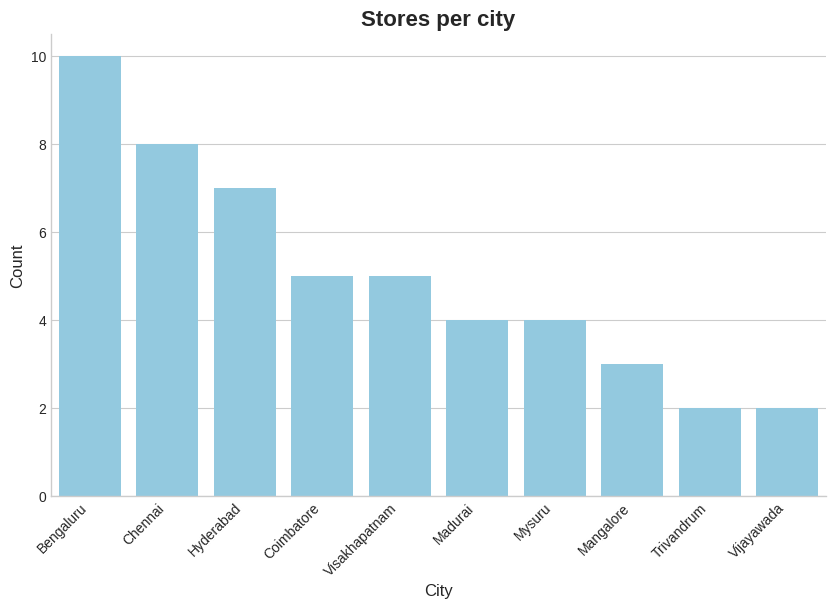

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=stores_per_city.index, y=stores_per_city['store_id'], color='skyblue')

# Title and labels
plt.title('Stores per city', fontsize=16, weight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Adjust the rotation angle as needed

# Remove spines on the top and right sides
sns.despine()

# Show the plot
plt.show()

We can see that we have 10 stores in Bangluru which are 5 time greater as compared to Vijayawada which has only 2

We need to get the discounted price for some analysis. So lets find it.

We will consider BOGOF as 50% off for calculation purpose

We also have to take care of cashbacks. We will substract the cashbacks from the base price to get the discounted price

In [ ]:

# Creating a column off which contains all the values of promo_type except BOGOF which is converted into 50% off
events['off'] = events['promo_type'].apply(lambda x: '50%' if x == 'BOGOF' else x)
# Then we will get the percentage part of the promo_type
events['off'] = events['off'].apply(lambda x: x.split(' ')[0])
# Then we will remove % and convert it into float and divide by 100 for calculation
events['off_num'] = events['off'].apply(lambda x: x.rstrip('%')).astype('float32')/100
# Now we will calculate the discounted price
events['discount_price'] = events.apply(lambda row: row['base_price'] * (1 - row['off_num']) if '%' in row['off'] else row['base_price'] - row['off_num']*100, axis=1)

As we don't need off and off_num anymore we will drop them

In [ ]:
events.drop(['off','off_num'], axis=1, inplace=True)

Now that we have base price and discounted price we can compare the total revenue before promotion and after promotion

We will create 2 new columns one for revenue before promotion and one for revenue after promotion

In [ ]:
events['sales_before_promotion'] = events['base_price'] * events['quantity_sold(before_promo)']
events['sales_after_promotion'] = events['discount_price'] * events['quantity_sold(after_promo)']

We will compare the revenue before and after promotion on diwali and sankranti

In [ ]:
# Merging campaigns data and events data
total_revenue_per_campaign = pd.merge(campaigns,events, on='campaign_id', how='inner')
# Calculating the total revenue for each campaign and converting it into millions
total_revenue_per_campaign = round(total_revenue_per_campaign.groupby('campaign_name')[['sales_before_promotion','sales_after_promotion']].sum()/1000000,2)
# Changing the names of columns
total_revenue_per_campaign.columns = ['sales_before_promotion (millions)', 'sales_after_promotion (millions)']
# We will stack the column for visualization purpose
total_revenue_per_campaign = pd.DataFrame(total_revenue_per_campaign.iloc[:,[0,1]].stack())
total_revenue_per_campaign.reset_index([1],inplace=True)
total_revenue_per_campaign.columns = ['duration','sales']
total_revenue_per_campaign

,duration,sales
campaign_name,,
Diwali,sales_before_promotion (millions),82.57
Diwali,sales_after_promotion (millions),160.29
Sankranti,sales_before_promotion (millions),58.13
Sankranti,sales_after_promotion (millions),87.70


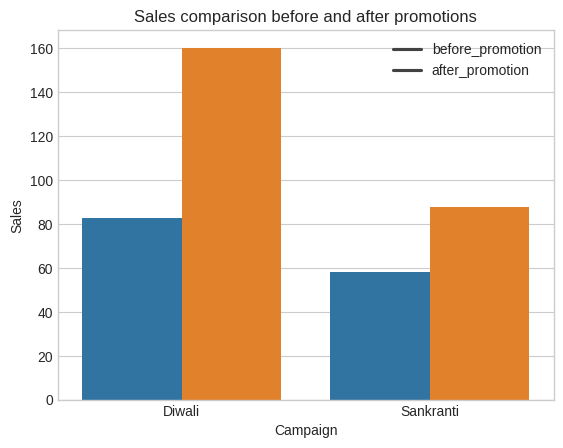

In [ ]:
# Create a barplot with combined data
sns.barplot(x=total_revenue_per_campaign.index, y='sales', hue='duration', data=total_revenue_per_campaign)

# Add a title and axis labels
plt.title('Sales comparison before and after promotions')
plt.xlabel('Campaign')
plt.ylabel('Sales')
# Customizing legend with border and shadow
plt.legend(['before_promotion','after_promotion'], loc='upper right', fancybox=True, shadow=True)

# Show the plot
plt.show()

We can clearly see that the sales on diwali doubled during promotion but the sales on sankranti increased by 1/3 of the sales before sankranti

Now we will find Icrimental Sold Units persentage(ISU%) for diwali

Icrimental Sold Units persentage(ISU%) is the percentage increase/decrease in the quantity sold(before promotion) and quantity sold(after promotion)

In [ ]:
ISU_percentage_diwali = events[events.campaign_id == 'CAMP_DIW_01']
ISU_percentage_diwali = pd.merge(ISU_percentage_diwali, products, on='product_code')[['category','quantity_sold(before_promo)','quantity_sold(after_promo)']]
ISU_percentage_diwali = ISU_percentage_diwali.groupby('category').sum(['quantity_sold(before_promo)','quantity_sold(after_promo)'])
# Here we calculate the ISU% and round it to 1 decimal place
ISU_percentage_diwali['ISU%'] = round(((ISU_percentage_diwali['quantity_sold(after_promo)'] - ISU_percentage_diwali['quantity_sold(before_promo)'])/ISU_percentage_diwali['quantity_sold(before_promo)'])*100,1)
# Ranking by ISU% percentage
ISU_percentage_diwali['ISU%_rank'] = ISU_percentage_diwali['ISU%'].rank(method='first').astype('int8')
ISU_percentage_diwali.sort_values(by='ISU%_rank', inplace=True)

In [ ]:
ISU_percentage_diwali

,quantity_sold(before_promo),quantity_sold(after_promo),ISU%,ISU%_rank
category,,,,
Grocery & Staples,58129,68620,18.0,1
Personal Care,16843,22074,31.1,2
Home Care,13326,23938,79.6,3
Combo1,16791,50769,202.4,4
Home Appliances,5230,18003,244.2,5


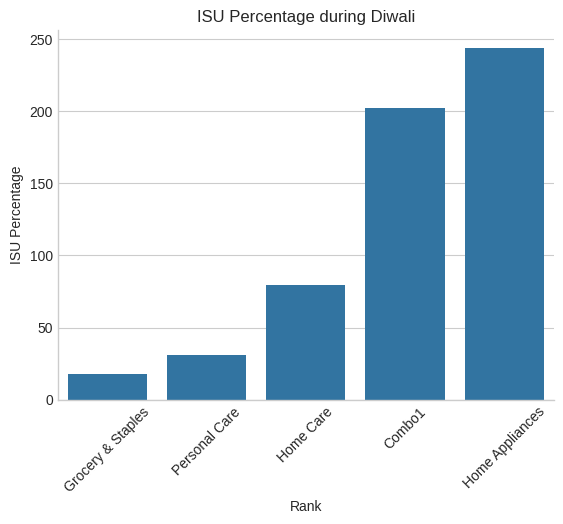

In [ ]:
sns.barplot(x=ISU_percentage_diwali.index, y='ISU%', data=ISU_percentage_diwali)

# Customize the plot
plt.title('ISU Percentage during Diwali')
plt.xlabel('Rank')
plt.ylabel('ISU Percentage')
plt.xticks(rotation=45)
sns.despine()

# Show the plot
plt.show()

We can see that Home Appliances got the highest ISU% as a lot of people upgrade their household items during diwali.

Combo items also have good ISU% as people find it convenient and cheap to buy combo items for gift as it saves them a lot of effort to select items individually and also it saves some money as retailers give some discounted on combi items

We check of there are any products that are over discounted

In [ ]:
highly_discounted_products = events[(events.base_price > 500) & (events.promo_type == 'BOGOF')].product_code
highly_discounted_products = products[products.product_code.isin(highly_discounted_products)].drop_duplicates()
highly_discounted_products

,product_code,product_name,category
9,P14,Atliq_waterproof_Immersion_Rod,Home Appliances
13,P08,Atliq_Double_Bedsheet_set,Home Care


We can see that there are only 2 products which have price greater than 500 and are promoted using BOGOF promotion type

I think these products were over discounted which can lead to lose. We will further analyze them.

Now lets Check which were 5 most successful products during promotion.

We will find it using Incremental Revenue(IR%) of each product. Also we will find to which category those products belong.

Incremental revenue percentage(IR%) is the percentage increase/decrease in the revenue of products before and after the promotion

This will enable us to consider those products during next promotion.

In [ ]:
IR_percentage_products = pd.merge(products, events, on='product_code', how='inner')
IR_percentage_products = IR_percentage_products.groupby(['product_code','category']).sum()[['sales_before_promotion','sales_after_promotion']]
# Here we calculated the IR% and rounded it to 1 decimal place
IR_percentage_products['IR%'] = round(((IR_percentage_products.sales_after_promotion - IR_percentage_products.sales_before_promotion)/IR_percentage_products.sales_before_promotion)*100,1)
IR_percentage_products.reset_index('category',inplace=True)

<ipython-input-14-40db015cd9ab>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  IR_percentage_products = IR_percentage_products.groupby(['product_code','category']).sum()[['sales_before_promotion','sales_after_promotion']]


In [ ]:
IR_percentage_products

,category,sales_before_promotion,sales_after_promotion,IR%
product_code,,,,
P01,Grocery & Staples,4478880,4.303177e+06,-3.9
P02,Grocery & Staples,32061660,3.067401e+07,-4.3
P03,Grocery & Staples,5599512,7.673781e+06,37.0
P04,Grocery & Staples,10851800,1.543548e+07,42.2
P05,Home Care,316910,2.056312e+05,-35.1
P06,Home Care,2160905,1.391910e+06,-35.6
P07,Home Care,1377600,2.447550e+06,77.7
P08,Home Care,5001570,8.959510e+06,79.1
P09,Personal Care,601270,3.851000e+05,-36.0


<ipython-input-16-a97bf9cd3d15>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product_code', y='IR%', data=IR_percentage_products, palette=['red' if x < 0 else 'green' for x in IR_percentage_products['IR%']])


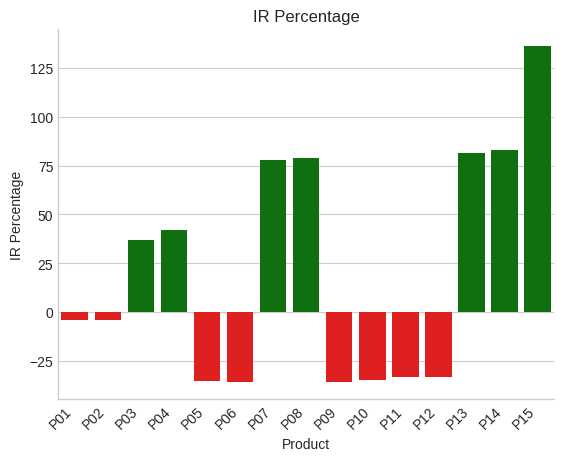

In [ ]:
sns.barplot(x='product_code', y='IR%', data=IR_percentage_products, palette=['red' if x < 0 else 'green' for x in IR_percentage_products['IR%']])

# Customize the plot
plt.title('IR Percentage')
plt.xlabel('Product')
plt.ylabel('IR Percentage')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
sns.despine()

# Show the plot
plt.show()

We can see that combo product got the highest IR% as people tend to buy combo products as gift to save time and budget.

Also sales of some products decreased.
These products belong to those categories that have low ISU%.
These categories are usually not in demand during diwali and sankranti


The product no 8 and 14 also did well which were over discounted above

Now lets check which stores did good during promotions

We will do this by calculating the IR% for each store

In [ ]:
IR_percentage_stores = pd.merge(stores,events, on='store_id', how='inner')
IR_percentage_stores = IR_percentage_stores.groupby(['store_id','city']).sum()[['sales_before_promotion','sales_after_promotion']]
# Here we calculated the IR% and rounded it to 1 decimal place
IR_percentage_stores['IR%'] = round(((IR_percentage_stores.sales_after_promotion - IR_percentage_stores.sales_before_promotion)/IR_percentage_stores.sales_before_promotion)*100,2)
IR_percentage_stores.reset_index('city', inplace=True)
# Getting the top 10 stores
IR_percentage_stores_t10 = IR_percentage_stores.sort_values(by='IR%', ascending=False).head(10)
IR_percentage_stores_t10

<ipython-input-17-06c400f09931>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  IR_percentage_stores = IR_percentage_stores.groupby(['store_id','city']).sum()[['sales_before_promotion','sales_after_promotion']]


,city,sales_before_promotion,sales_after_promotion,IR%
store_id,,,,
STMDU-0,Madurai,2678534,5.508251e+06,105.64
STMYS-3,Mysuru,3223037,6.585904e+06,104.34
STBLR-0,Bengaluru,3401065,6.908049e+06,103.11
STMYS-1,Mysuru,3539283,7.173387e+06,102.68
STCHE-7,Chennai,3257935,6.596596e+06,102.48
STBLR-7,Bengaluru,3355236,6.752643e+06,101.26
STCHE-4,Chennai,3556860,7.093490e+06,99.43
STCHE-3,Chennai,3223142,6.378482e+06,97.90
STBLR-6,Bengaluru,3404012,6.696217e+06,96.72


In [ ]:
IR_percentage_stores_b10 = IR_percentage_stores.sort_values(by='IR%').head(10)
IR_percentage_stores_b10

,city,sales_before_promotion,sales_after_promotion,IR%
store_id,,,,
STMYS-0,Mysuru,2819804,3.931603e+06,39.43
STCHE-1,Chennai,3063257,4.441701e+06,45.00
STHYD-1,Hyderabad,3098163,4.520895e+06,45.92
STVSK-3,Visakhapatnam,2292504,3.347900e+06,46.04
STMLR-0,Mangalore,1630896,2.415157e+06,48.09
STVSK-4,Visakhapatnam,2410893,3.589341e+06,48.88
STCBE-4,Coimbatore,2526645,3.806447e+06,50.65
STHYD-3,Hyderabad,3423444,5.187499e+06,51.53
STBLR-1,Bengaluru,3179262,4.865991e+06,53.05


There is no strong relation of top 10 and bottom 10 stores with city.
But we can see Bengaluru and Chennai are present three time in top 10 store so if we want to open a new store we can consider those cities

Now lets examine which promo_type performed better

In [ ]:
promo_comparison = events.groupby('promo_type').sum()[['quantity_sold(before_promo)','quantity_sold(after_promo)','sales_before_promotion','sales_after_promotion']]
promo_comparison['IR%'] = round(((promo_comparison.sales_after_promotion - promo_comparison.sales_before_promotion)/promo_comparison.sales_before_promotion)*100,2)
promo_comparison['ISU%'] = round(((promo_comparison['quantity_sold(after_promo)'] - promo_comparison['quantity_sold(before_promo)'])/promo_comparison['quantity_sold(before_promo)'])*100,2)
promo_comparison

<ipython-input-35-961a1db4fba1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  promo_comparison = events.groupby('promo_type').sum()[['quantity_sold(before_promo)','quantity_sold(after_promo)','sales_before_promotion','sales_after_promotion']]


,quantity_sold(before_promo),quantity_sold(after_promo),sales_before_promotion,sales_after_promotion,IR%,ISU%
promo_type,,,,,,
25% OFF,44007,38290,9173467,5.998952e+06,-34.61,-12.99
33% OFF,63321,90576,36540540,3.497718e+07,-4.28,43.04
50% OFF,21243,28174,2162951,1.436288e+06,-33.60,32.63
500 Cashback,22299,63180,66897000,1.579500e+08,136.11,183.33
BOGOF,58180,215253,25927230,4.762211e+07,83.68,269.98


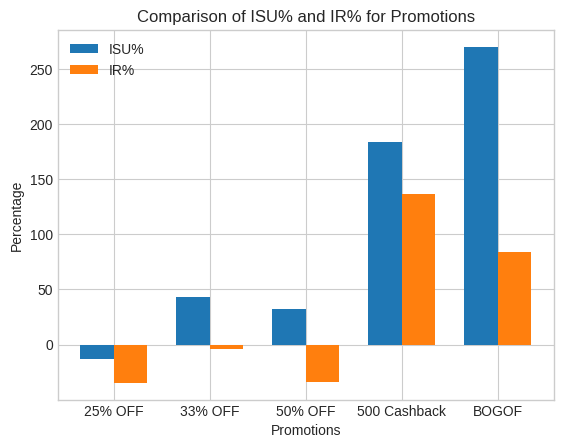

In [ ]:
promotions = promo_comparison.index
isu_percentages = promo_comparison['ISU%']
ir_percentages = promo_comparison['IR%']

bar_width = 0.35  # Width of the bars

fig, ax = plt.subplots()

# Plot 'ISU%' bars
ax.bar(np.arange(len(promotions)), isu_percentages, width=bar_width, label='ISU%')

# Plot 'IR%' bars next to 'ISU%' bars
ax.bar(np.arange(len(promotions)) + bar_width, ir_percentages, width=bar_width, label='IR%')

ax.set_xlabel('Promotions')
ax.set_ylabel('Percentage')
ax.set_title('Comparison of ISU% and IR% for Promotions')
ax.set_xticks(np.arange(len(promotions)) + bar_width / 2)
ax.set_xticklabels(promotions)
ax.legend()

plt.show()

We can see that Cashback has the best balance between ISU and IR.

On the other hand we can also observe agood insight from this plot. As BOGOF and 50% off usually mean the same thing in terms of revenue. We can focus more on BOGOF instead of 50% off as BOGOF has good ISU and IR as compared to 50% off.

This can be due to the fact that people love when they get some thing for free😄

Another insight that all the % off promotion type don't do very well.
This can be due to the fact that they are very common.

Usually retailers increase the price and then apply off on the products to make them look discounted.😄

In [ ]:
p = pd.merge(products, events, on='product_code', how='inner')
p

,product_code,product_name,category,event_id,store_id,campaign_id,base_price,promo_type,quantity_sold(before_promo),quantity_sold(after_promo),discount_price,sales_before_promotion,sales_after_promotion
0,P01,Atliq_Masoor_Dal (1KG),Grocery & Staples,c4db5b,STTRV-0,CAMP_DIW_01,172,33% OFF,164,236,115.239998,28208,2.719664e+04
1,P01,Atliq_Masoor_Dal (1KG),Grocery & Staples,260ff2,STMYS-2,CAMP_SAN_01,172,33% OFF,204,291,115.239998,35088,3.353484e+04
2,P01,Atliq_Masoor_Dal (1KG),Grocery & Staples,2f3e5d,STCHE-2,CAMP_SAN_01,172,33% OFF,333,402,115.239998,57276,4.632648e+04
3,P01,Atliq_Masoor_Dal (1KG),Grocery & Staples,df45ee,STHYD-3,CAMP_DIW_01,172,33% OFF,309,534,115.239998,53148,6.153816e+04
4,P01,Atliq_Masoor_Dal (1KG),Grocery & Staples,c1e0b6,STCHE-6,CAMP_SAN_01,172,33% OFF,273,379,115.239998,46956,4.367596e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,P15,Atliq_Home_Essential_8_Product_Combo,Combo1,536fbf,STMLR-2,CAMP_DIW_01,3000,500 Cashback,217,659,2500.000000,651000,1.647500e+06
1496,P15,Atliq_Home_Essential_8_Product_Combo,Combo1,879d9a,STBLR-2,CAMP_DIW_01,3000,500 Cashback,318,915,2500.000000,954000,2.287500e+06
1497,P15,Atliq_Home_Essential_8_Product_Combo,Combo1,87bb82,STCBE-0,CAMP_SAN_01,3000,500 Cashback,126,275,2500.000000,378000,6.875000e+05
1498,P15,Atliq_Home_Essential_8_Product_Combo,Combo1,a42141,STMDU-1,CAMP_SAN_01,3000,500 Cashback,85,195,2500.000000,255000,4.875000e+05


Lets see if there is any relation between promo_type and product category

We will use chi2 test for that(value close to 1 means good relation while value close to 0 means weak relation

In [ ]:
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoder = LabelEncoder()
p['Product_Category_Encoded'] = label_encoder.fit_transform(p['category'])
p['Promotion_Type_Encoded'] = label_encoder.fit_transform(p['promo_type'])

# Create a contingency table
contingency_table = pd.crosstab(p['Product_Category_Encoded'], p['Promotion_Type_Encoded'])

# Apply Cramér's V
chi2, _, _, _ = chi2_contingency(contingency_table)
num_obs = np.sum(contingency_table.values)
v = np.sqrt(chi2 / (num_obs * (min(contingency_table.shape) - 1)))

print(f"Cramér's V: {v}")

Cramér's V: 0.7541551564499178


Looking at the cramer's value there is a good relation between promo_type and category

Lets check the distribution of category with respect to promo_type

Cross-Tabulation:
promo_type         25% OFF  33% OFF  50% OFF  500 Cashback  BOGOF
category                                                         
Combo1                   0        0        0           100      0
Grocery & Staples      100      200        0             0    100
Home Appliances          0        0        0             0    200
Home Care              200        0        0             0    200
Personal Care          100        0      300             0      0


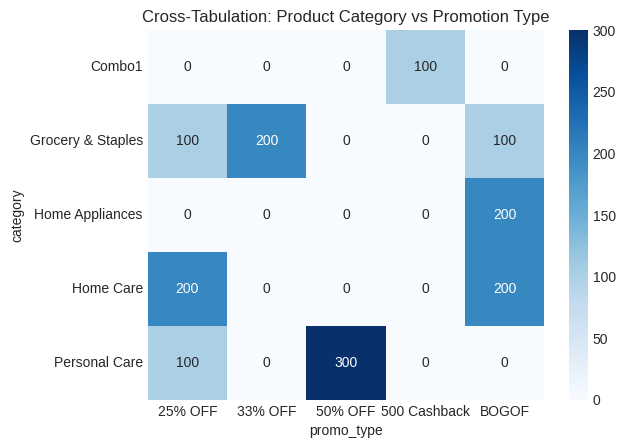

In [ ]:
# Create a cross-tabulation
cross_tab = pd.crosstab(p['category'], p['promo_type'])

# Display the cross-tabulation
print("Cross-Tabulation:")
print(cross_tab)

# Visualize the cross-tabulation using a heatmap
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d')
plt.title('Cross-Tabulation: Product Category vs Promotion Type')
plt.show()

We san see the the count of each promo_type for each category

Now to see which combination of promo_type and category have better return. This will help us to consider those combinations for next promotion

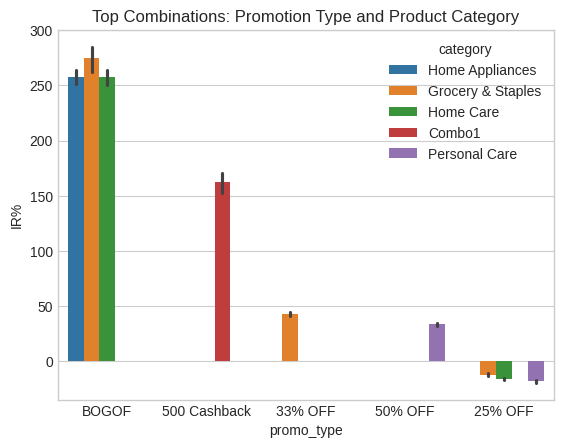

In [ ]:
p['IR%'] = round(((p.sales_after_promotion - p.sales_before_promotion)/p.sales_before_promotion)*100,2)
# Plotting it
sns.barplot(x='promo_type', y='IR%', hue='category', data=sorted_p)
plt.title('Top Combinations: Promotion Type and Product Category')
plt.ylabel('IR%')
plt.show()

We can clearly see that the categories which are associated with BOGOF and cashback have higher IR% while discount based promotions are not doing well.

This is all for now.
Hope you liked the analysis and learned something.

Until next time Allah Hafiz